## Autoencoder for dimensionality reduction

#### Data Preparation:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import datasets as ds

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')


#Clusterers
from sklearn.cluster import DBSCAN

#Sampling
from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterGrid

#For mapper
import gtda.plotting
from gtda.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    Projection, Eccentricity, Entropy,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph
)
from mapper_utils import *

#For filter functions and measurements
from sklearn.decomposition import PCA
from scipy.stats import entropy

#For reproducibility
rs = 12345
from numpy.random import seed
seed(rs)
from tensorflow.random import set_seed
set_seed(rs)

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
(xtrain, ytrain), (xtest, ytest) = ds.mnist.load_data()

In [3]:
Xtrain = pd.DataFrame(xtrain.reshape((xtrain.shape[0], 28*28)), 
                      columns = ['pixel' + str(i) for i in range(1,28*28+1)])

Xtest = pd.DataFrame(xtest.reshape((xtest.shape[0], 28*28)), 
                      columns = ['pixel' + str(i) for i in range(1,28*28+1)])

Ytrain = pd.Series(ytrain,name='label')

Ytest = pd.Series(ytest,name='label')

data_train = pd.concat([Xtrain,Ytrain], axis=1)
data_test = pd.concat([Xtest,Ytest],axis=1)

In [4]:
data_train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [5]:
data_train['label'].value_counts()/len(data_train)

1    0.112367
7    0.104417
3    0.102183
2    0.099300
9    0.099150
0    0.098717
6    0.098633
8    0.097517
4    0.097367
5    0.090350
Name: label, dtype: float64

In [6]:
data_test

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [7]:
X_train = data_train[[col for col in data_train.columns if 'pixel' in col]]
y_train = data_train['label']

X_test = data_test[[col for col in data_test.columns if 'pixel' in col]]
y_test = data_test['label']

Rescaling data so that each data attribute is contained in the interval $[0,1]$

In [8]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [9]:
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [10]:
X_train

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Autoencoder architecture

In [11]:
act = 'sigmoid'
input_img = Input(shape=(784,))
e0 = Dense(units = 300, activation = act)(input_img)
e3 = Dense(units = 50, activation = act)(e0)
encoded = Dense(units = 2,activation = act)(e3)
d2 = Dense(units = 50, activation = act)(encoded)
d5 = Dense(units = 300, activation = act)(d2)
decoded = Dense(units = 784, activation = act)(d5) 


autoencoder = Model(input_img, decoded)

encoder = Model(input_img,encoded)

autoencoder.compile(optimizer = 'Adam', loss = 'MSE', metrics = ['MSE'])

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 50)                15050     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
_________________________________________________________________
dense_3 (Dense)              (None, 50)                150       
_________________________________________________________________
dense_4 (Dense)              (None, 300)               15300     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               235984

2021-10-04 01:00:29.432673: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-04 01:00:29.433228: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Fit autoencoder

In [12]:
history = autoencoder.fit(X_train, X_train, epochs = 50, \
                          shuffle = True, validation_data = (X_test,X_test))

2021-10-04 01:00:32.518599: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/50
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0691 - MSE: 0.0691 - val_loss: 0.0593 - val_MSE: 0.0593
Epoch 2/50
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0572 - MSE: 0.0572 - val_loss: 0.0520 - val_MSE: 0.0520
Epoch 3/50
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0511 - MSE: 0.0511 - val_loss: 0.0485 - val_MSE: 0.0485
Epoch 4/50
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0482 - MSE: 0.0482 - val_loss: 0.0460 - val_MSE: 0.0460
Epoch 5/50
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0455 - MSE: 0.0455 - val_loss: 0.0439 - val_MSE: 0.0439
Epoch 6/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0436 - MSE: 0.0436 - val_loss: 0.0426 - val_MSE: 0.0426
Epoch 7/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0425 - MSE: 0.0425 - val_loss: 0.0416 - val_MSE: 0.0416
Epoch 8/50
1875/1875 [==============================] -

### Verifying there is no overfitting

dict_keys(['loss', 'MSE', 'val_loss', 'val_MSE'])


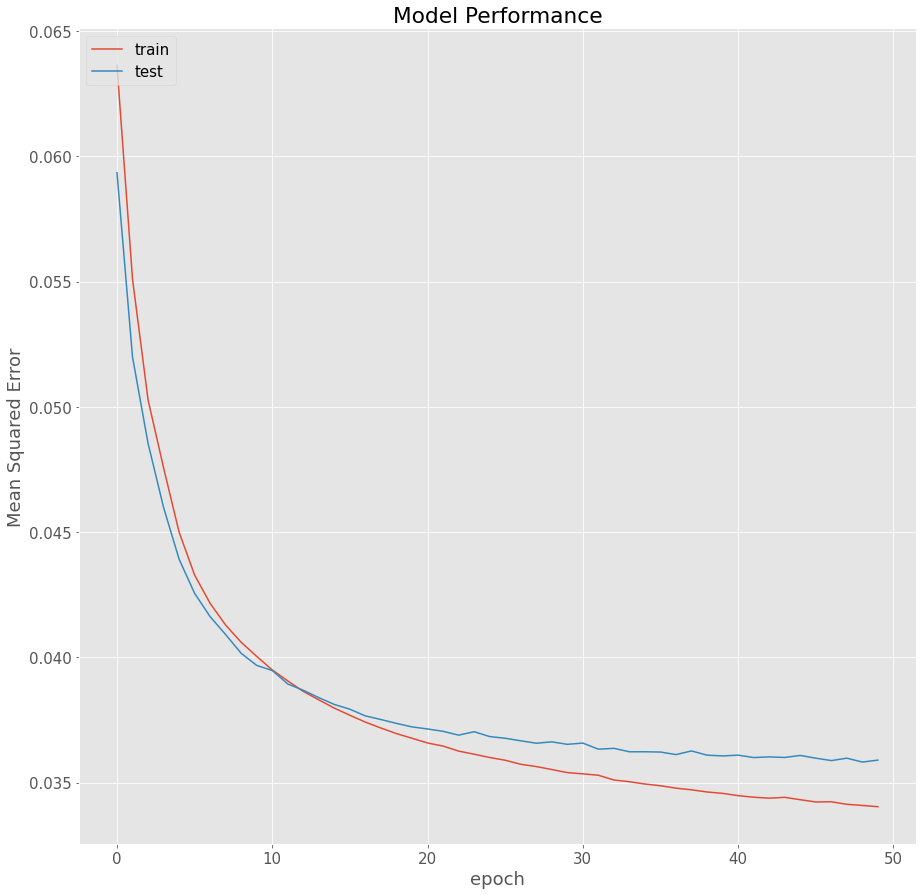

In [13]:
plt.rcParams.update({'font.size': 15})

path = 'Images/'

print(history.history.keys())
plt.figure(figsize=(15,15))
plt.plot(history.history['MSE'])
plt.plot(history.history['val_MSE'])
plt.title('Model Performance')
plt.ylabel('Mean Squared Error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig(path+'AE_validation_mnist.png', dpi = 300)
plt.show()

In [14]:
labels_dict = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6',\
         7:'7', 8:'8', 9:'9'}

In [15]:
sample_data = pd.concat([pd.DataFrame(X_test), data_test['label']], axis = 1)
sample_images = []
labels = list(sample_data['label'].unique())
labels.sort()
for label in labels:
    image = sample_data[sample_data['label'] == label].sample(1, random_state = rs), label
    sample_images.append(image)

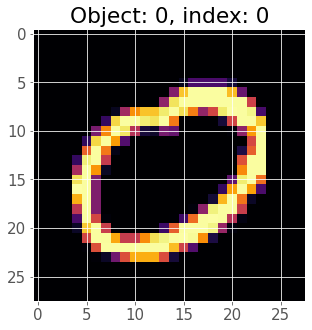

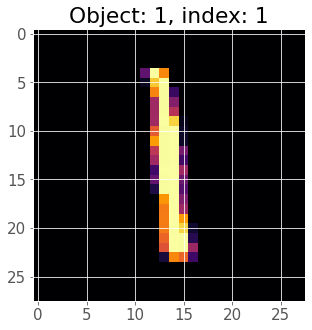

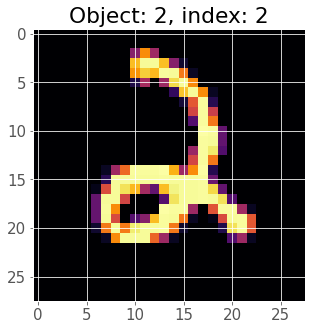

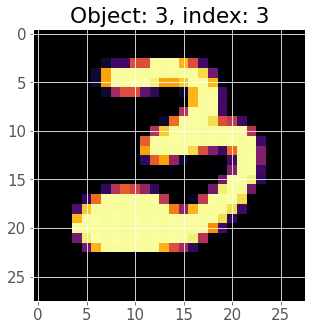

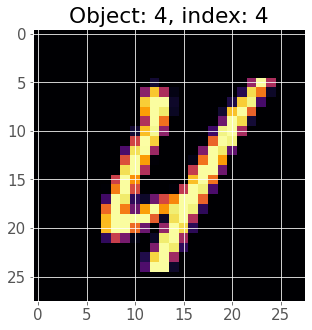

In [16]:
for i,image in enumerate(sample_images[:5]):
    x = image[0].drop('label',axis=1)
    plt.figure(figsize=(5,5))
    idx = list(image[0].label.values).pop()
    object_label = labels_dict[idx]
    plt.title('Object: ' + object_label + ', ' + 'index: ' + str(idx))
    plt.imshow(x.to_numpy().reshape(28,28), cmap = 'inferno')
    #plt.savefig(path+'sample_images_' + object_label + '.png', dpi=300)

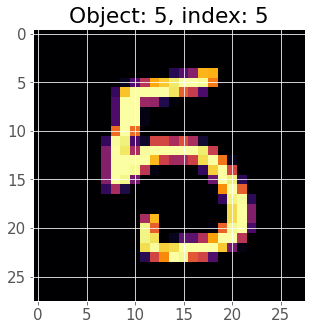

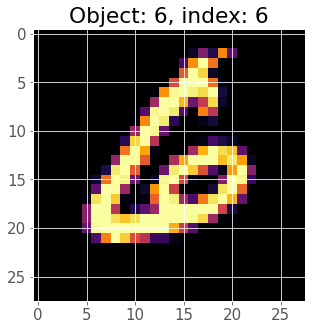

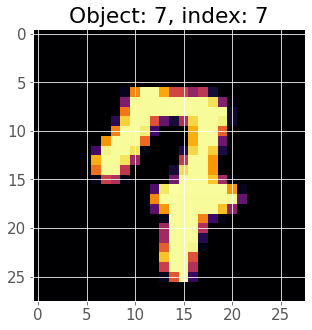

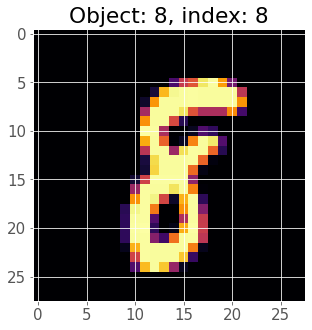

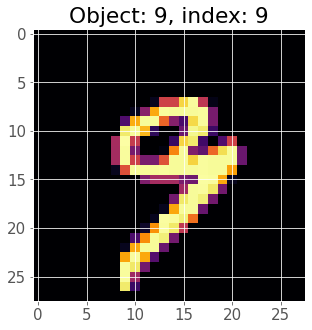

In [17]:
for i,image in enumerate(sample_images[5:]):
    x = image[0].drop('label',axis=1)
    plt.figure(figsize=(5,5))
    idx = list(image[0].label.values).pop()
    object_label = labels_dict[idx]
    plt.title('Object: ' + object_label + ', ' + 'index: ' + str(idx))
    plt.imshow(x.to_numpy().reshape(28,28), cmap = 'inferno')
    #plt.savefig(path+'sample_images_' + object_label + '.png', dpi=300)

### Using the encoder to project onto a lower-dimensional space

In [18]:
proyection_test = encoder.predict(X_test)

In [19]:
P1,P2 = proyection_test[:,0],proyection_test[:,1] 

In [20]:
mapper_input_full_ae = pd.concat((pd.Series(P1, name = 'P1'), 
                               pd.Series(P2, name = 'P2'),
                               pd.Series(y_test,name='label'), 
                               X_test), 
                              axis=1)

In [21]:
mapper_input_full_ae

,P1,P2,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.440952,0.038836,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.282324,0.603337,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.062460,0.136962,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.747493,0.799474,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.700109,0.390944,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.174875,0.637851,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.538101,0.780442,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.438241,0.180419,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.211465,0.316976,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Visualizing the projection

<AxesSubplot:xlabel='P1', ylabel='P2'>

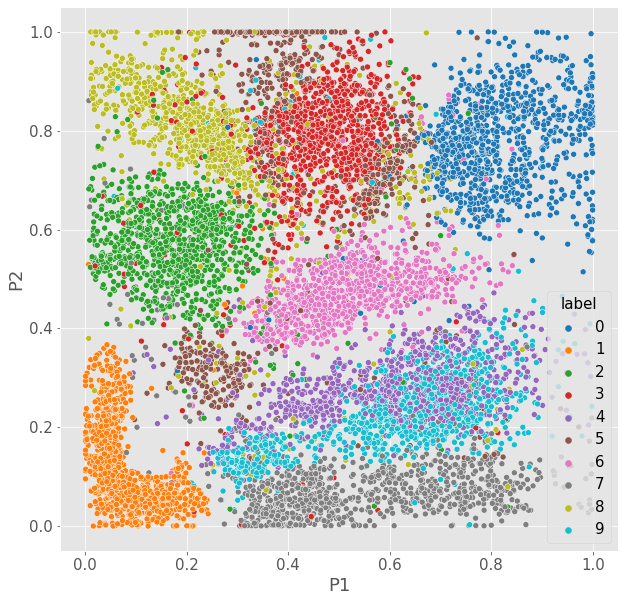

In [23]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=mapper_input_full_ae['P1'],\
                y=mapper_input_full_ae['P2'], hue=data_test['label'], palette='tab10')
#plt.savefig(path+'MNIST_Encoder.png',dpi=300)

In [24]:
#Save the final dataset that will be used as a mapper filter function.
#mapper_input_full_ae.to_csv('mnist_mapper_input_full_ae.csv')
#mapper_input_full_ae = pd.read_csv('mnist_mapper_input_full_ae.csv').drop('Unnamed: 0',axis=1)

### Maper trials

In [25]:
#Get PCA projections
pca = PCA(n_components = 2).fit(X_train).transform(X_test)
PCA1,PCA2 = pca[:,0],pca[:,1] 
mapper_input_full_pca = pd.concat([pd.Series(PCA1, name = 'P1'), 
                                   pd.Series(PCA2, name = 'P2'), 
                                   pd.Series(y_test,name='label'),
                                   X_test], axis=1)

<AxesSubplot:xlabel='P1', ylabel='P2'>

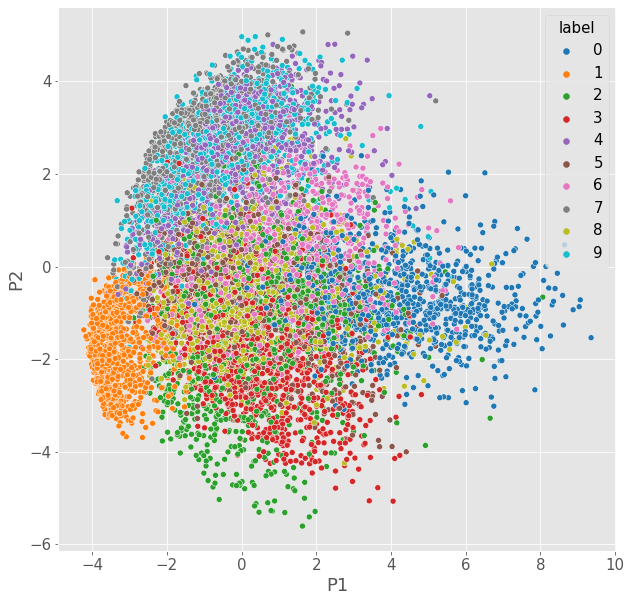

In [33]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=mapper_input_full_pca['P1'],\
                y=mapper_input_full_pca['P2'], hue=data_test['label'], palette='tab10')

In [26]:
data_ae_full = mapper_input_full_ae[:]
data_pca_full = mapper_input_full_pca[:]

In [27]:
data_ae_full

,P1,P2,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.440952,0.038836,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.282324,0.603337,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.062460,0.136962,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.747493,0.799474,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.700109,0.390944,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.174875,0.637851,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.538101,0.780442,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.438241,0.180419,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.211465,0.316976,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
data_pca_full

,P1,P2,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,-1.303019,2.932528,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.081163,-3.747387,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-3.709908,-1.689579,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.838852,0.442898,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.742273,2.802257,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.185262,-2.146055,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,2.257649,-2.714041,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,-1.059563,2.340679,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,-1.231489,-0.425868,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
X_ae_f,y_ae_f = data_ae_full.drop('label',axis=1), data_ae_full['label']

X_pca_f,y_pca_f = data_pca_full.drop('label',axis=1), data_pca_full['label']

X_ae_s, _, y_ae_s, _ = train_test_split(X_ae_f,y_ae_f, 
                                            train_size = 0.25,
                                            stratify = y_ae_f, 
                                            random_state = rs)

X_pca_s, _, y_pca_s, _ = train_test_split(X_pca_f,y_pca_f, 
                                          train_size = 0.25,
                                          stratify = y_pca_f, 
                                          random_state = rs)

In [30]:
all_labels = y_pca_s.values
all_value, all_counts = np.unique(all_labels, return_counts=True)
all_entropy = entropy(pk = all_counts/len(all_labels))

print('Entropy of the data: ' + str(all_entropy))
print('Counts: ' + str(all_counts))

Entropy of the data: 2.3008267527953854
Counts: [245 284 258 253 245 223 239 257 244 252]


### PCA2 and Autoencoder bottleneck visualizations

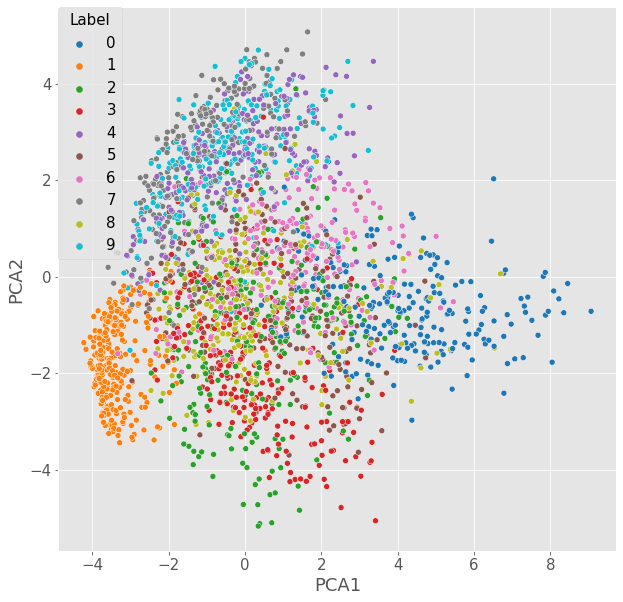

In [31]:
plt.figure(figsize=(10,10))
g = sns.scatterplot(x=X_pca_s['P1'], y=X_pca_s['P2'], hue=y_pca_s, palette='tab10')
g.set(xlabel='PCA1', ylabel='PCA2')
g.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0., title='Label')
#plt.savefig(path+'minstPCA2viz.png', dpi = 300);

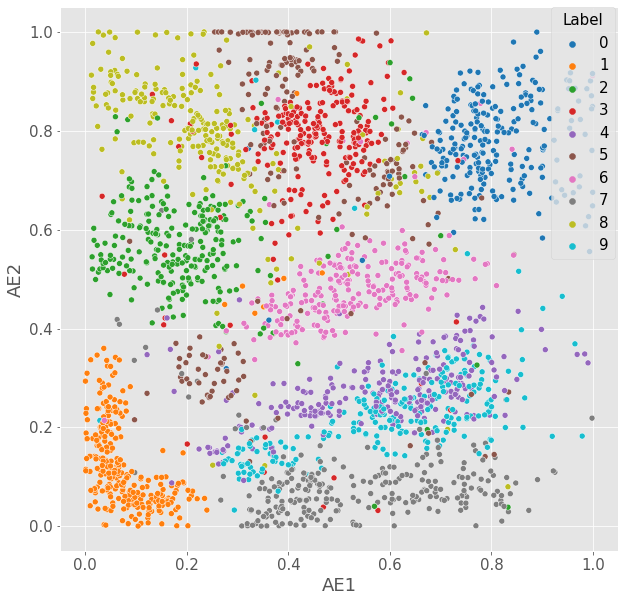

In [32]:
plt.figure(figsize=(10,10))
g = sns.scatterplot(x=X_ae_s['P1'], y=X_ae_s['P2'], hue=y_ae_s, palette='tab10')
g.set(xlabel='AE1', ylabel='AE2')
g.legend(bbox_to_anchor=(0.88, 1), loc=2, borderaxespad=0., title='Label')
#plt.savefig(path+'mnistAutoencoderviz.png', dpi = 300)

### Defining the parameter grids for the trials

In [34]:
hyperparams_pca = {'eps': [0.5, 1],
                   'min_samples':[3, 5],
                   'n_intervals': [int(step) for step in np.linspace(10, 30, 12)],
                   'overlap_frac': [0.1, 0.25, 0.5]
                   }




param_grid_pca = ParameterGrid(hyperparams_pca)
hyperparams_pca

{'eps': [0.5, 1],
 'min_samples': [3, 5],
 'n_intervals': [10, 11, 13, 15, 17, 19, 20, 22, 24, 26, 28, 30],
 'overlap_frac': [0.1, 0.25, 0.5]}

In [35]:
Mapper_info_pca = get_mappers(param_grid = param_grid_pca, 
                              X_m = X_pca_s, 
                              y_m = y_pca_s, 
                              rs = rs, 
                              lense = Projection(columns = ['P1','P2']))

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.2s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   4.7s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.6s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.2s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipel

[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.4s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.7s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.2s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.2s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.5s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.9s
[Pipel

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.4s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.5s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipel

[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.6s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.0s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.9s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.2s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.7s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.2s
[Pipel

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.3s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.2s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.5s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.2s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipel

[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.7s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.6s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.8s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   2.4s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.2s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.9s
[Pipel

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.5s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.5s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipel

[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.6s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.7s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   2.3s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.7s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   2.0s
[Pipel

In [36]:
hyperparams_ae = {'eps': [0.5, 1],
                   'min_samples':[3, 5],
                   'n_intervals': [int(step) for step in np.linspace(10, 30, 12)],
                   'overlap_frac': [0.1, 0.25, 0.5]
                   }

param_grid_ae = ParameterGrid(hyperparams_ae)
hyperparams_ae

{'eps': [0.5, 1],
 'min_samples': [3, 5],
 'n_intervals': [10, 11, 13, 15, 17, 19, 20, 22, 24, 26, 28, 30],
 'overlap_frac': [0.1, 0.25, 0.5]}

In [37]:
Mapper_info_ae = get_mappers(param_grid = param_grid_ae, 
                             X_m = X_ae_s, 
                             y_m = y_ae_s, 
                             rs = rs,
                             lense = Projection(columns = ['P1','P2']))

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.4s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.7s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.2s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipel

[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.6s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.6s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.8s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.8s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.7s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   2.1s
[Pipel

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.4s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.2s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.4s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.2s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipel

[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.9s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   2.2s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.9s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   2.8s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.6s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   2.9s
[Pipel

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.5s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.5s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipel

[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.7s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   3.1s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   3.6s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.8s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   3.7s
[Pipel

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.5s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.6s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.6s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.6s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipel

[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.8s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   4.1s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.9s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   5.1s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.2s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.8s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   4.7s
[Pipel

In [38]:
Results_pca = Mapper_info_pca[:]
Results_ae = Mapper_info_ae[:]
Results_pca['lense'] = 'PCA'
Results_ae['lense'] = 'Autoencoder'

In [39]:
Mappers = pd.concat((Results_pca,Results_ae), axis=0)
#Mappers.to_csv('MNIST_comparison.csv')

In [40]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set_style("whitegrid", {"axes.facecolor": ".95", 'axes.labelcolor': '.25',\
                          'figure.facecolor': 'white', 'text.color': '.25',\
                           'font.family': ['DejaVu Sans']})
sns.set_context({"font.size": 15,
            "axes.labelsize": 15,
            "axes.titlesize": 15,
            "xtick.labelsize": 15,
            "ytick.labelsize": 15,
            "legend.fontsize": 15,
            "legend.title_fontsize": 15})

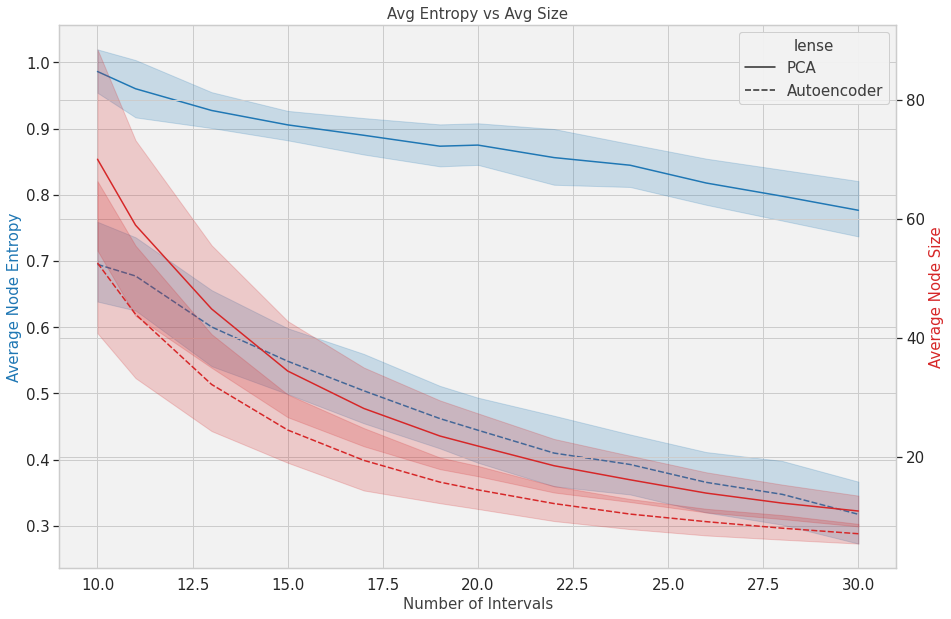

In [41]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax1.set_title('Avg Entropy vs Avg Size')
ax1.set_xlabel('Number of Intervals')
ax1.set_ylabel('Average Node Entropy', color = 'tab:blue')
ax2 = sns.lineplot(x='Number of Intervals', y='Average Node Entropy', data = Mappers.reset_index(),\
                color = 'tab:blue', style = 'lense')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2.set_ylabel('Average Node Size', color = 'tab:red')
ax2 = sns.lineplot(x='Number of Intervals', y='Average Node Size', data = Mappers.reset_index(),\
                   color = 'tab:red', style = 'lense')
ax2.tick_params(axis='y')
plt.show()

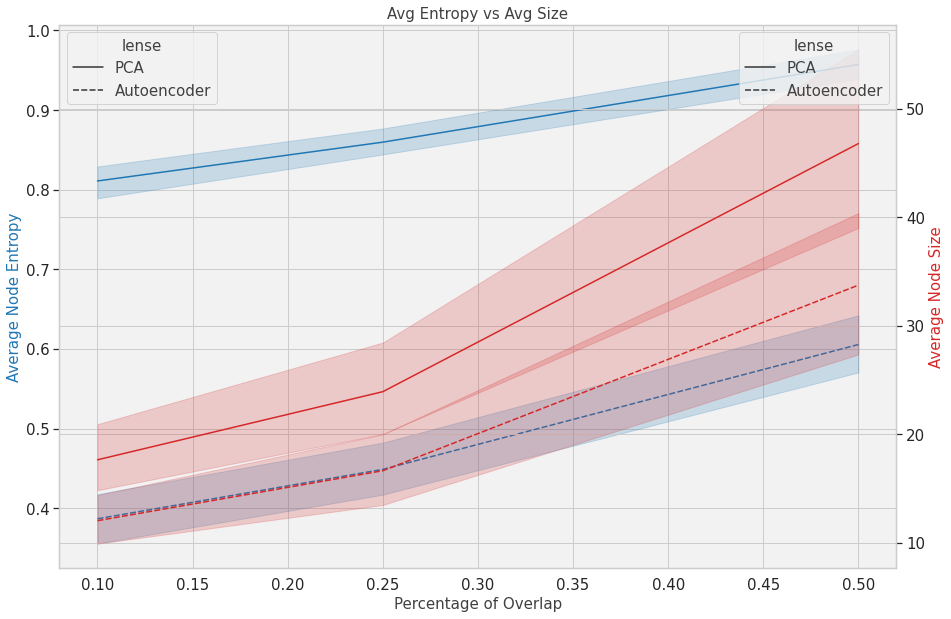

In [42]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax1.set_title('Avg Entropy vs Avg Size')
ax1.set_xlabel('Percentage of Overlap')
ax1.set_ylabel('Average Node Entropy', color = 'tab:blue')
ax2 = sns.lineplot(x='Percentage of Overlap', y='Average Node Entropy', data = Mappers.reset_index(),\
                color = 'tab:blue', style = 'lense')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2.set_ylabel('Average Node Size', color = 'tab:red')
ax2 = sns.lineplot(x='Percentage of Overlap', y='Average Node Size', data = Mappers.reset_index(),\
                   color = 'tab:red', style = 'lense')
ax2.tick_params(axis='y')
plt.show()

<AxesSubplot:xlabel='Average Node Size', ylabel='Average Node Entropy'>

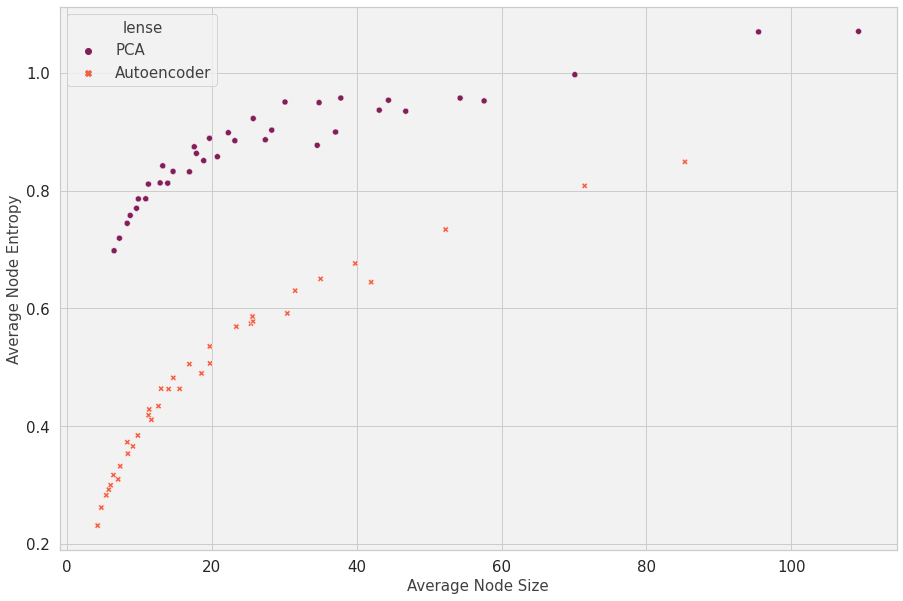

In [44]:
sns.scatterplot(x = "Average Node Size", y = "Average Node Entropy",
                 palette = 'rocket',
                 hue = 'lense',
                 style = 'lense',
                 data = Mappers.reset_index())
#plt.savefig(path+'MNIST_AEvsPCA_results.png',dpi=300)

In [45]:
selected_params = {
    'n_intervals': 15,
    'overlap_frac': 0.25,
    'eps': 1.0,
    'min_samples': 3
}

In [46]:
# Define filter function
filter_func_pca = PCA(n_components = 2)

# Define cover
cover_pca = CubicalCover(n_intervals=selected_params['n_intervals'],
                         overlap_frac=selected_params['overlap_frac'])

# Choose clustering algorithm - default is DBSCAN
clusterer_pca = DBSCAN(eps = selected_params['eps'], min_samples = selected_params['min_samples'])

# Configure parallelism of clustering step
n_jobs = -1

#plotly_params = {"node_trace": {"marker_colorscale":'viridis'}}

# Initialise pipeline
selected_pipe_pca = make_mapper_pipeline(
    filter_func=filter_func_pca,
    cover=cover_pca,
    clustering_preprocessing= None, 
    clusterer=clusterer_pca,
    graph_step=True,
    verbose=False,
    n_jobs=n_jobs,
    contract_nodes = False,
)

In [47]:
fig_pca = plot_interactive_mapper_graph(selected_pipe_pca, 
                                        X_pca_s,
                                        layout="fr",
                                        color_by_columns_dropdown=False, 
                                        node_color_statistic=lambda x: np.argmax(np.bincount(x)),
                                        color_variable = y_pca_s.values)

In [48]:
fig_pca

In [49]:
# Define filter function
filter_func_ae = Projection(columns = ['P1', 'P2'])

# Define cover
cover_ae = CubicalCover(n_intervals=selected_params['n_intervals'],
                          overlap_frac=selected_params['overlap_frac'])

# Choose clustering algorithm - default is DBSCAN
clusterer_ae = DBSCAN(eps = selected_params['eps'], min_samples = selected_params['min_samples'])


# Configure parallelism of clustering step
n_jobs = 1

# Initialise pipeline
selected_pipe_ae = make_mapper_pipeline(
    filter_func=filter_func_ae,
    cover=cover_ae,
    clustering_preprocessing= None, 
    clusterer=clusterer_ae,
    graph_step=True,
    verbose=False,
    n_jobs=n_jobs,
    contract_nodes = False
)

In [50]:
fig_ae = plot_interactive_mapper_graph(selected_pipe_ae,
                                       X_ae_s,
                                       layout="fr",
                                       color_by_columns_dropdown=False,
                                       node_color_statistic=lambda x: np.argmax(np.bincount(x)),
                                       color_variable = y_ae_s.values)

In [51]:
fig_ae

In [52]:
#Generate mapper graph and its nodes and observations in each node
graph = selected_pipe_ae.fit_transform(X_ae_s)

node_elements = graph.vs["node_elements"]
node_ids = graph.vs["pullback_set_label"]
subg_info = data_test[:]
subg_compare = X_ae_s.merge(subg_info, how = 'inner', left_index = True, right_index = True)
columns_compare = [col for col in subg_info if 'x' not in col ]
subgroups = subg_compare[columns_compare]
every = {0:'0',
         1:'1',
         2:'2',
         3:'3',
         4:'4',
         5:'5',
         6:'6',
         7:'7',
         8:'8',
         9:'9'}

In [53]:
#Select interesting node in the mapper (node id in hovering label)
'''
node_of_interest = 35 #0 manifold (footwear): 35, 19, 1

#Get columns to reconstruct images
cols = [col for col in X_ae_s.columns if 'pixel' in col]

#Extract the atributes (pixels) of the observations of each node
relevant_info = X_ae_s.iloc[node_elements[node_of_interest]][cols]

#Extract label info
sg = subgroups.iloc[node_elements[node_of_interest]]

#Generate info for table visualization
sg['Labels ' + '(' + str(len(sg)) + ' observations)'] = sg['label'].replace(every);

sg['Percentages of ' + 'node ' + str(node_of_interest)] = sg['label']

df = ((sg.groupby('Labels ' + '(' + str(len(sg)) + ' observations)')
       .count()
       .sort_values(by = 'Percentages of ' + 'node ' + str(node_of_interest),
                    ascending = False)/len(sg)))[['Percentages of ' + 'node ' + str(node_of_interest)]]

cm = sns.light_palette("green", as_cmap=True)

df.style.format({'Percentages of ' + 'node ' + str(node_of_interest): "{:.2%}"}).background_gradient(cmap=cm)
'''

In [54]:
#See the pictures of at most 5 of the observations
'''
i = 0
for idx, row in relevant_info.iterrows():
    i = i+1
    if i <= 25:
        plt.figure(figsize=(5,5))
        plt.title('Node: ' + str(node_of_interest) + ', id: ' + str(idx))
        plt.imshow(row.to_numpy().reshape(28,28), cmap = 'inferno')
        #plt.savefig(path+'sample_node_images_' + object_label + '.png', dpi=300)
'''